In [1]:
%matplotlib inline
import sys
sys.path.append("../")
sys.path.append('/home/hao/Research/probtorch/')
import numpy as np
import torch.nn as nn
import math
import matplotlib.pyplot as plt
from plots import *
from utils import *
from objectives import *
from torch.distributions.normal import Normal
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
import time
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [2]:
N = 300
K = 3
D = 2

## Model Parameters
SAMPLE_SIZE = 10
NUM_HIDDEN1 = 8
STAT_SIZE = 8
NUM_LATENTS =  D
## Training Parameters
BATCH_SIZE = 20
NUM_EPOCHS = 1000
LEARNING_RATE = 1e-3
CUDA = torch.cuda.is_available()
PATH = 'gibbs-z-v3-varying-radius'

gpu = torch.device('cuda:0')

In [3]:
Xs = torch.from_numpy(np.load('rings_varying_radius/obs.npy')).float()
# STATES = torch.from_numpy(np.load('rings_dataset/states.npy')).float()
OBS_MU = torch.from_numpy(np.load('rings_varying_radius/obs_mu.npy')).float()
OBS_RAD = torch.from_numpy(np.load('rings_varying_radius/obs_rad.npy')).float()
NUM_SEQS = Xs.shape[0]
NUM_BATCHES = int((Xs.shape[0] / BATCH_SIZE))

In [7]:
class Enc_z(nn.Module):
    def __init__(self, num_hidden=8,
                       sample_size=SAMPLE_SIZE,
                       batch_size=BATCH_SIZE):
        super(self.__class__, self).__init__()
        self.diff = nn.Sequential(
            nn.Linear(2*D, D))
        
        self.log_prob = nn.Sequential(
            nn.Linear(3, 2),
            nn.Tanh(),
            nn.Linear(2, 2),
            nn.Tanh(),
            nn.Linear(2, 1))
        
        self.prior_pi = torch.ones(K) * (1./ K)
        self.noise_sigma = torch.ones((sample_size, batch_size, N, 1)) *  0.05
        if CUDA:
            self.prior_pi = self.prior_pi.cuda().to(gpu)
            self.noise_sigma = self.noise_sigma.cuda().to(gpu)
  
    def forward(self, obs, obs_mu, obs_rad, sample_size, batch_size, decay_factor):
        obs_mu_c1 = obs_mu[:, :, 0, :].unsqueeze(-2).repeat(1,1,N,1)
        obs_mu_c2 = obs_mu[:, :, 1, :].unsqueeze(-2).repeat(1,1,N,1)
        obs_mu_c3 = obs_mu[:, :, 2, :].unsqueeze(-2).repeat(1,1,N,1)
        
        obs_rad_c1 = obs_rad[:, :, 0, :].unsqueeze(-2).repeat(1,1,N,1)
        obs_rad_c2 = obs_rad[:, :, 1, :].unsqueeze(-2).repeat(1,1,N,1)
        obs_rad_c3 = obs_rad[:, :, 2, :].unsqueeze(-2).repeat(1,1,N,1)        
        ## analytically compute L2 norm
        dist_c1 = (self.diff(torch.cat((obs, obs_mu_c1), -1)) ** 2).sum(-1).unsqueeze(-1)
        dist_c2 = (self.diff(torch.cat((obs, obs_mu_c2), -1)) ** 2).sum(-1).unsqueeze(-1)
        dist_c3 = (self.diff(torch.cat((obs, obs_mu_c3), -1)) ** 2).sum(-1).unsqueeze(-1)
        
        pot1 = self.log_prob(torch.cat((log_norm_c1.exp(), obs_rad_c1, self.noise_sigma), -1))   
        pot2 = self.log_prob(torch.cat((log_norm_c2.exp(), obs_rad_c2, self.noise_sigma), -1))     
        pot3 = self.log_prob(torch.cat((log_norm_c3.exp(), obs_rad_c3, self.noise_sigma), -1))    

        pots = torch.cat((pot1 - log_norm_c1, pot2 - log_norm_c2, pot3 - log_norm_c3), -1) # S * B * N * K


        q_pi = F.softmax(pots, -1)
        
        q = probtorch.Trace()
        p = probtorch.Trace()
        
        z = cat(F.softmax(pots * (1 - decay_factor), -1)).sample()
        _ = q.variable(cat, probs=q_pi, value=z, name='zs')
        _ = p.variable(cat, probs=self.prior_pi, value=z, name='zs')
        return q, p
    
def initialize():
    enc_z = Enc_z()
    if CUDA:
        enc_z.cuda().to(gpu)
    optimizer =  torch.optim.Adam(list(enc_z.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))    
    return enc_z, optimizer

In [8]:
enc_z, optimizer = initialize()

In [9]:
EUBOs = []
ELBOs = []
ESSs = []

flog = open('results/log-' + PATH + '.txt', 'w+')
flog.write('EUBO\tELBO\tESS\n')
flog.close()
for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    indices = torch.randperm(NUM_SEQS)
    EUBO = 0.0
    ELBO = 0.0
    ESS = 0.0
    for step in range(NUM_BATCHES):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        obs = Xs[batch_indices]
        obs_mu = OBS_MU[batch_indices].repeat(SAMPLE_SIZE, 1, 1, 1)
        obs_rad = OBS_RAD[batch_indices].repeat(SAMPLE_SIZE, 1, 1, 1)
        obs = shuffler(obs).repeat(SAMPLE_SIZE, 1, 1, 1)
        if CUDA:
            obs = obs.cuda().to(gpu)
            obs_mu = obs_mu.cuda().to(gpu)
            obs_rad = obs_rad.cuda().to(gpu)
        eubo, elbo, ess = Eubo_gibbs_z(enc_z, obs, obs_mu, obs_rad, N, K, D, SAMPLE_SIZE, BATCH_SIZE, gpu, 0.9**epoch, noise_sigma=0.05)
        ## gradient step
        eubo.backward()
        optimizer.step()
        EUBO += eubo.item()
        ELBO += elbo.item()
        ESS += ess.item()
    EUBOs.append(EUBO / NUM_BATCHES)
    ELBOs.append(ELBO / NUM_BATCHES)
    ESSs.append(ESS / NUM_BATCHES) 
    flog = open('results/log-' + PATH + '.txt', 'a+')
    print('%.3f\t%.3f\t%.3f'
            % (EUBO/NUM_BATCHES, ELBO/NUM_BATCHES, ESS/NUM_BATCHES), file=flog)
    flog.close()
    time_end = time.time()
    print('epoch=%d, EUBO=%.3f, ELBO=%.3f, ESS=%.3f (%ds)'
            % (epoch, EUBO/NUM_BATCHES, ELBO/NUM_BATCHES, ESS/NUM_BATCHES, 
               time_end - time_start))

epoch=0, EUBO=-5098.173, ELBO=-374844.185, ESS=3.573 (1s)
epoch=1, EUBO=-5118.647, ELBO=-374310.748, ESS=3.573 (1s)
epoch=2, EUBO=-4797.863, ELBO=-371505.029, ESS=3.591 (1s)
epoch=3, EUBO=-4447.943, ELBO=-361663.467, ESS=3.654 (1s)
epoch=4, EUBO=-3986.306, ELBO=-346679.673, ESS=3.755 (1s)
epoch=5, EUBO=-3885.286, ELBO=-330962.323, ESS=3.874 (1s)
epoch=6, EUBO=-3736.153, ELBO=-316186.922, ESS=4.005 (1s)
epoch=7, EUBO=-3644.895, ELBO=-304938.821, ESS=4.119 (1s)
epoch=8, EUBO=-3691.683, ELBO=-295952.658, ESS=4.219 (1s)
epoch=9, EUBO=-3693.442, ELBO=-289380.200, ESS=4.294 (1s)
epoch=10, EUBO=-3712.376, ELBO=-283790.770, ESS=4.369 (1s)
epoch=11, EUBO=-3549.067, ELBO=-278448.257, ESS=4.434 (1s)
epoch=12, EUBO=-3617.418, ELBO=-274596.260, ESS=4.491 (1s)
epoch=13, EUBO=-3641.436, ELBO=-271238.319, ESS=4.544 (1s)
epoch=14, EUBO=-3700.064, ELBO=-267319.529, ESS=4.598 (1s)
epoch=15, EUBO=-3699.772, ELBO=-263701.910, ESS=4.653 (1s)
epoch=16, EUBO=-3673.944, ELBO=-260834.221, ESS=4.694 (1s)
epoch=1

KeyboardInterrupt: 

CPU times: user 2.09 s, sys: 26.6 ms, total: 2.12 s
Wall time: 2.16 s


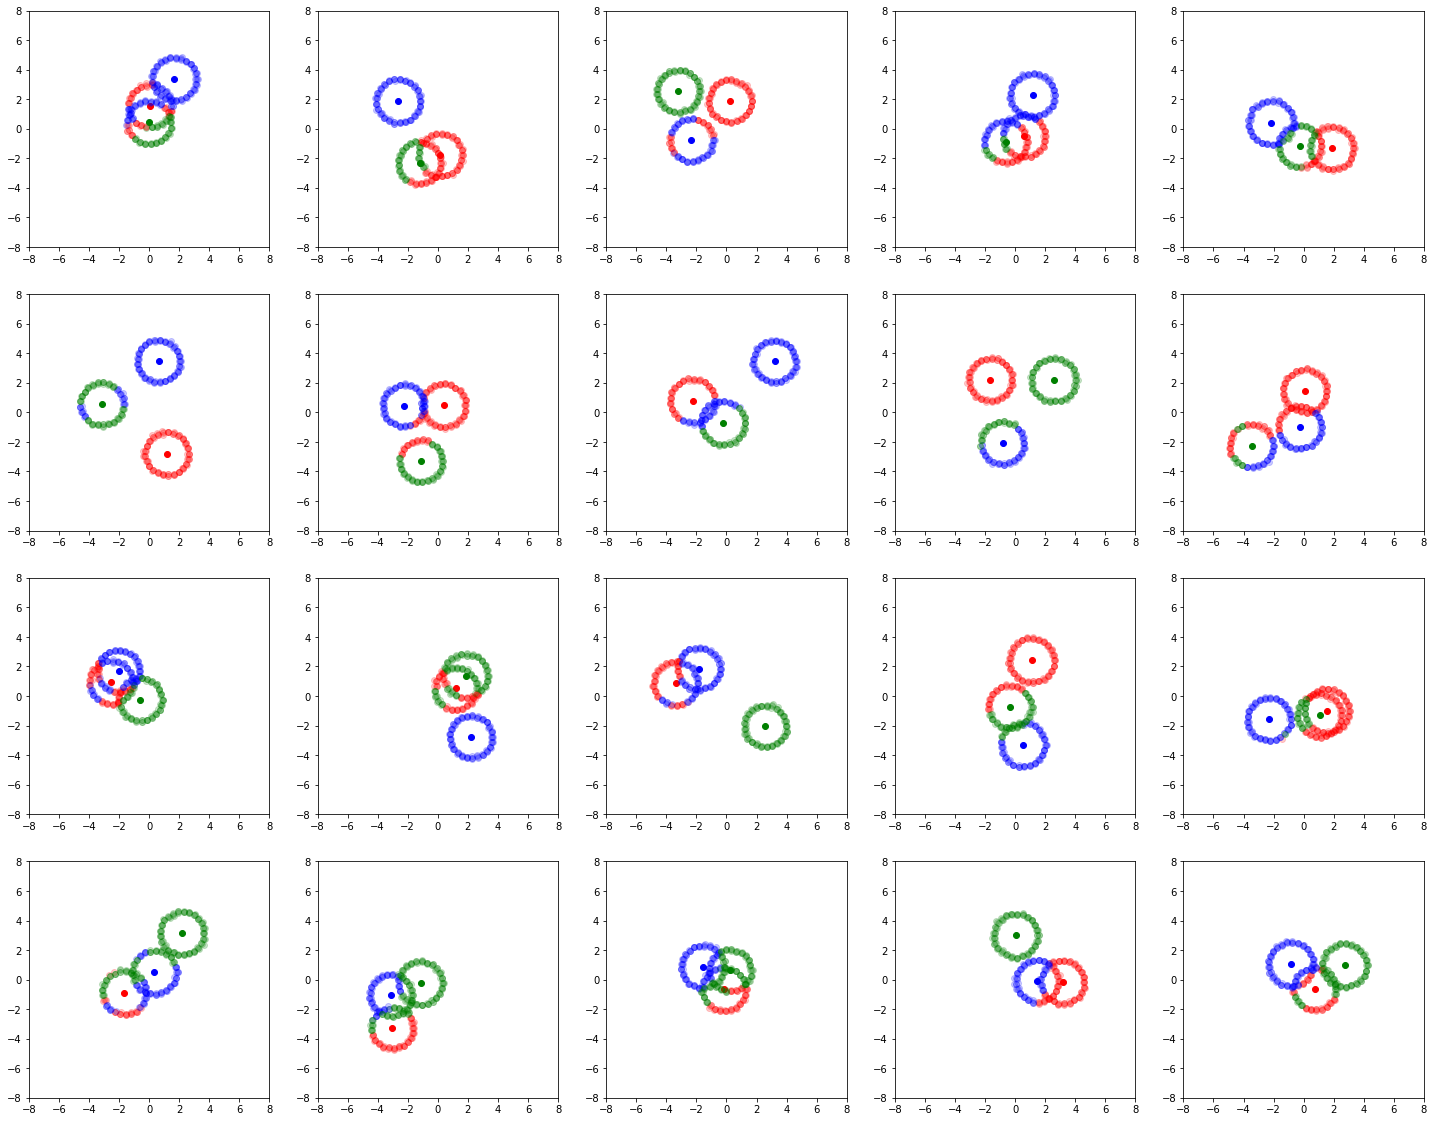

In [10]:
BATCH_SIZE_TEST = 20

def sample_single_batch(num_seqs, Xs, OBS_MU, OBS_RAD, sample_size, batch_size, gpu):
    indices = torch.randperm(num_seqs)
    batch_indices = indices[0*batch_size : (0+1)*batch_size]
    obs = Xs[batch_indices]
    obs_mu = OBS_MU[batch_indices].repeat(sample_size, 1, 1, 1)
    obs_rad = OBS_RAD[batch_indices].repeat(sample_size, 1, 1, 1)
    obs = shuffler(obs).repeat(sample_size, 1, 1, 1)
    if CUDA:
        obs = obs.cuda().to(gpu)
        obs_mu = obs_mu.cuda().to(gpu)
        obs_rad = obs_rad.cuda().to(gpu)
    return obs, obs_mu, obs_rad

def test(enc_z, obs, obs_mu, obs_rad, sample_size, batch_size):
        ## update z -- cluster assignments
    q_z, p_z = enc_z(obs, obs_mu, obs_rad, sample_size, batch_size, 0)
    log_p_z = p_z['zs'].log_prob
    log_q_z = q_z['zs'].log_prob ## S * B * N
    states = q_z['zs'].value
    log_obs_n = True_Log_likelihood(obs, states, obs_mu, obs_rad, K, D, 0.05, gpu=gpu, cluster_flag=False)
    log_weights_local = log_obs_n + log_p_z - log_q_z
    weights_local = F.softmax(log_weights_local, 0).detach()
    return q_z, weights_local

def plot_samples(obs, q_eta, q_z, K, batch_size, PATH):
    colors = ['r', 'b', 'g']
    fig = plt.figure(figsize=(25,20))
    xs = obs[0].cpu().data.numpy()
    mu = obs_mu[0].cpu().data.numpy()
    zs = q_z['zs'].dist.probs[0].cpu().data.numpy()
    for b in range(batch_size):
        ax = fig.add_subplot(int(batch_size / 5), 5, b+1)
        x = xs[b]
        z = zs[b]
        mu_b = mu[b]
        assignments = z.argmax(-1)
        for k in range(K):
            xk = x[np.where(assignments == k)]
            ax.scatter(xk[:, 0], xk[:, 1], c=colors[k], alpha=0.2)
            ax.scatter(mu_b[k, 0], mu_b[k, 1], c=colors[k])
        ax.set_ylim([-8, 8])
        ax.set_xlim([-8, 8])
    plt.savefig('results/modes-' + PATH + '.svg')
    
obs, obs_mu, obs_rad = sample_single_batch(NUM_SEQS, Xs, OBS_MU, OBS_RAD, SAMPLE_SIZE, BATCH_SIZE_TEST, gpu)
q_z, weights_local = test(enc_z, obs, obs_mu, obs_rad, SAMPLE_SIZE, BATCH_SIZE_TEST)
%time plot_samples(obs, obs_mu, q_z, K, BATCH_SIZE_TEST, PATH)

In [ ]:
fig = plt.figure(figsize=(5,5))
colors = ['r', 'b', 'g']
ax = fig.add_subplot(111)
aob = obs[0,0].cpu().data.numpy()
az = q_z['zs'].value[:, 0].cpu().transpose(0,1).data.numpy()
az_pi = q_z['zs'].dist.probs[0,0].cpu().data.numpy()
aweight = weights_local[:,0].cpu().transpose(0, 1).data.numpy()
assign = az_pi.argmax(-1)
for k in range(K):
    xk = aob[np.where(assign == k)]
    awk = aweight[np.where(assign == k)]
    azk = az[np.where(assign == k)]
    ax.scatter(xk[:, 0], xk[:, 1], c=colors[k], alpha=0.2)
    ax.set_ylim([-8, 8])
    ax.set_xlim([-8, 8]) 

In [ ]:
plt.scatter(xk[:, 0], xk[:, 1], c=colors[k], alpha=0.2)
plt.xlim(0, 4)
plt.ylim(-4, 0)

In [ ]:
plt.scatter(xk[0, 0], xk[0, 1], c=colors[k], alpha=0.2)
plt.xlim(0, 4)
plt.ylim(-4, 0)

In [ ]:
awk[0]

In [ ]:
azk[0]


In [ ]:
plt.scatter(samples.data.numpy(), log_samples.exp().data.numpy())

In [ ]:
log_q = log_samples - (torch.Tensor([1.5])).log() - samples
plt.scatter(samples.data.numpy(), log_q.exp().data.numpy())